In [1]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path
import os
import pingouin as pg

# Import project specific modules and enable automatic reloading
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as erp
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import helpers

[8.5 6.5]


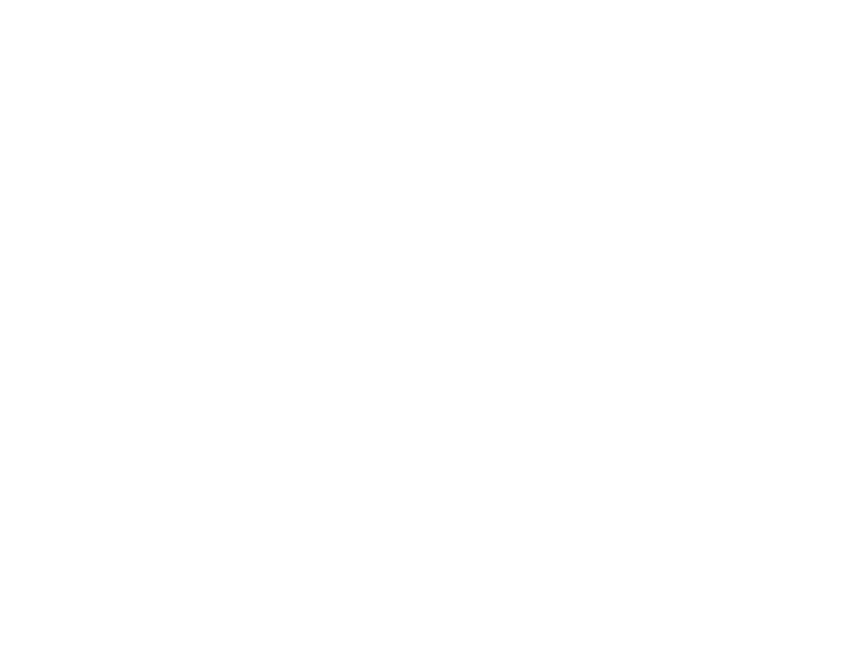

In [2]:
# Set up main figure plotting
%matplotlib ipympl
FigRegQ = Fig(num=1, grid=(4, 4), size=(8.5, 6.5), fontsize=6, constrained_layout=False, tight_layout=True)
print(FigRegQ.fig.get_size_inches())

In [3]:
# Define key lambda function
get_sesh_name = lambda day: "4 Hour" if day == 4 else f"Day {day}"

### Plot change in ROI orientation between groups

In [4]:
actrl = FigRegQ.subplot((4, 4, 13))
aani = FigRegQ.subplot((4, 4, 14))
acomb = FigRegQ.subplot((4, 4, 15))
ax = [actrl, aani, acomb]

days_compare = [-1, 4]
bin_size = 5
bin_edges = np.arange(0, 185, bin_size)
for grp, grp_name, a in zip([err.control_mice_good, err.ani_mice_good], ['Ctrl', 'ANI'], ax[:2]):
    orient_diff_all = []
    for mouse in grp:
        orient_diff = trc.calc_orientation_diff_bw_sessions(mouse, 'Shock', days_compare[0], 'Shock', days_compare[1])
        nhist = np.histogram(np.abs(orient_diff) * 180 / np.pi, bin_edges)[0]
        pbin = nhist / len(orient_diff)
        orient_diff_all.append(np.abs(orient_diff) * 180 / np.pi)
        a.plot(bin_edges[:-1] + bin_size / 2, pbin, linewidth=0.8)
    a.set_title(f"{grp_name}: {get_sesh_name(days_compare[0])} to {get_sesh_name(days_compare[1])}")
    a.set_xlabel("Change in ROI Orientation (degrees)")
    a.set_ylabel("Probability")
    ax[2].ecdf(np.concatenate(orient_diff_all).reshape(-1), linewidth=0.8)
ax[2].legend(['Ctrl', 'ANI'])
ax[2].set_xlabel("Change in ROI Orientation (degrees)")
ax[2].set_ylabel("Cumulative Probability")

Text(0, 0.5, 'Cumulative Probability')

### Plot min projection from day -1 to 4 hour session

In [5]:
# Set up projection subplots
aprojs = FigRegQ.subplot2grid(FigRegQ.gs[0:2, 0:4], grid=(1, 3), return_axes=True)

In [6]:
# an1 = FigRegQ.subplot((4, 4, 4))
# a4 = FigRegQ.subplot((4, 4, 8))
an1 = aprojs[1]
a4 = aprojs[2]
ax = [an1, a4]

days_compare = [-1, 4]
mouse = 'Marble07'
for a, day in zip(ax, days_compare):
    min_proj = trc.load_proj(mouse, 'Shock', days_compare[0], 'min')
    sns.heatmap(min_proj, cmap='grey', cbar=False, ax=a)
    sns.despine(ax=a)
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(get_sesh_name(day))

# FigRegQ.fig

In [7]:
# Set up colormaps
from matplotlib.colors import LinearSegmentedColormap

parula_custom = [[1, 1, 1, 1],
                 [0.2081, 0.1663, 0.5292, 1],
                 [0.1452714286, 0.7097571429, 0.6646285714],
                 [0.9763, 0.9831, 0.0538]]
                 
parula_custom = LinearSegmentedColormap.from_list("parula_nk", parula_custom)

In [8]:
import matplotlib.patches as patches
# afull = FigRegQ.subplot((4, 4, 1))
# afull = FigRegQ.subplot(FigRegQ.gs[0:2,0:2])
afull = aprojs[0]
azoom1 = FigRegQ.subplot((4, 4, 9))
azoom2 = FigRegQ.subplot((4, 4, 10))

mouse, arena, day1, day2 = 'Marble07', 'Shock', -1, 4
plt.rcParams['lines.linewidth'] = 0.3
# ax = trc.plot_ROIs_bw_sessions(mouse, arena, day1, arena, day2, ax=afull)  # Overlaid on min projection

# Plot over binary ROIs
rois1, rois2_reg = trc.register_all_ROIs(mouse, arena, day1, arena, day2, method="combined")
bkgrd = (rois1 > 0).astype(int) + (rois2_reg > 0).astype(int) * 2
trc.plot_ROIs_bw_sessions(mouse, arena, day1, arena, day2, proj='custom', custom_bkgrd=bkgrd, bkgrd_cmap=parula_custom, 
                          plot_all_rois=False, ax=afull)

xlims1 = [75, 130]
ylims1 = [229, 340]

xlims2 = [479, 536]
ylims2 = [214, 330]

plt.rcParams['lines.linewidth'] = 0.6
for azoom, xlims, ylims in zip([azoom1, azoom2], [xlims1, xlims2], [ylims1, ylims2]):
    # Add rectangles for zooming in
    # Create a Rectangle patch
    rect = patches.Rectangle((xlims[0], ylims[0]), np.diff(xlims)[0], np.diff(ylims)[0], linewidth=1, edgecolor='k', linestyle='--',
                             facecolor='none')
    
    # Add the patch to the Axes
    afull.add_patch(rect)

    # re-plot same are zoomed in
    trc.plot_ROIs_bw_sessions(mouse, arena, day1, arena, day2, proj='custom', custom_bkgrd=bkgrd, bkgrd_cmap=parula_custom, 
                              plot_all_rois=False, ax=azoom)
    azoom.set_xlim(xlims)
    azoom.set_ylim(ylims)

In [9]:
# # Attempt to match Kinsky 2020 Nat Comms S1 figures - need to adjust background coloring
# from matplotlib.colors import LinearSegmentedColormap

# rois1, rois2_reg = trc.register_all_ROIs(mouse, arena, day1, arena, day2, method="combined")
# bkgrd = (rois1 > 0).astype(int) + (rois2_reg > 0).astype(int)

# cmap_custom = [[1, 1, 1, 1], 
#                [0.267004, 0.004874, 0.329415, 1.      ],
#                [0.127568, 0.566949, 0.550556, 1.      ],
#                [0.993248, 0.906157, 0.143936, 1.      ]]

# parula_custom = [[1, 1, 1, 1],
#                  [0.2081, 0.1663, 0.5292, 1],
#                  [0.1452714286, 0.7097571429, 0.6646285714],
#                  [0.9763, 0.9831, 0.0538]]
                 
# cmap_custom = LinearSegmentedColormap.from_list("test_cmap", cmap_custom)
# parula_custom = LinearSegmentedColormap.from_list("parula_nk", parula_custom)

# trc.plot_ROIs_bw_sessions(mouse, arena, day1, arena, day2, proj='custom', custom_bkgrd=bkgrd, bkgrd_cmap=parula_custom, plot_all_rois=False)

### Plot delta orientation for this mouse only

In [10]:
ahist = FigRegQ.subplot((4, 4, 12))
mouse = 'Marble07'
base_day = -2
reg_days = [-1, 4, 1, 2, 7]
for reg_day in reg_days:
    orient_diff = trc.calc_orientation_diff_bw_sessions(mouse, 'Shock', base_day, 'Shock', reg_day)
    nhist = np.histogram(np.abs(orient_diff) * 180 / np.pi, bin_edges)[0]
    pbin = nhist / len(orient_diff)
    orient_diff_all.append(np.abs(orient_diff) * 180 / np.pi)
    ahist.plot(bin_edges[:-1] + bin_size / 2, pbin, linewidth=0.8)
ahist.set_xlabel("Change in ROI Orientation (degrees)")
ahist.set_ylabel("Probability")
ahist.legend([get_sesh_name(reg_day) for reg_day in reg_days])
ahist.set_title(f"{mouse} {get_sesh_name(base_day)} Cell Registration")

Text(0.5, 1.0, 'Marble07 Day -2 Cell Registration')

#### Extra plot for different days just in case

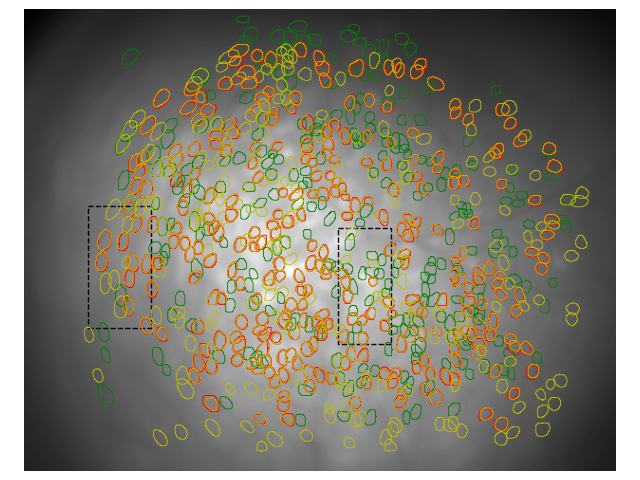

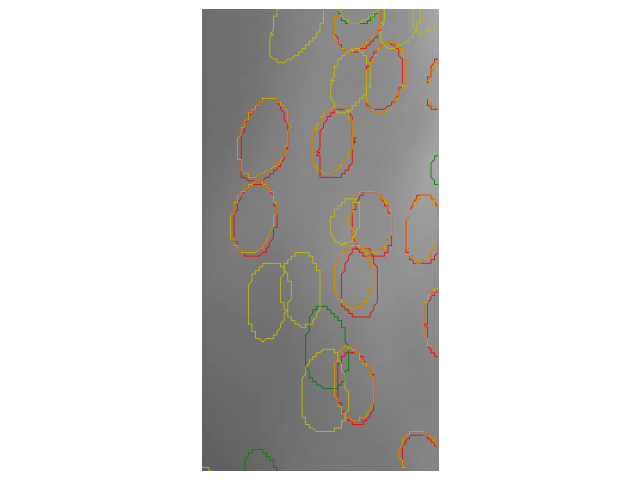

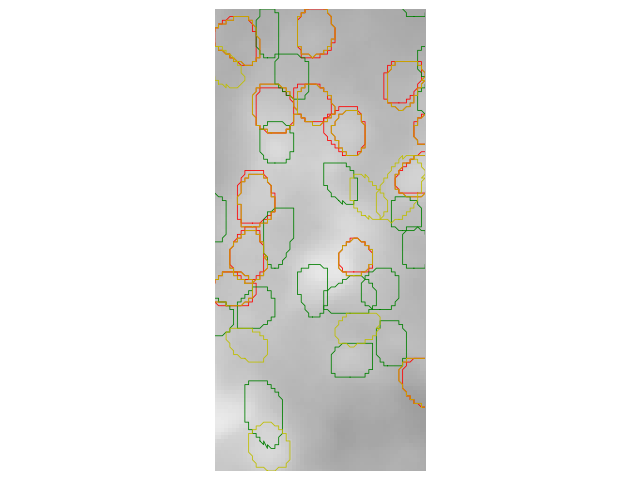

In [11]:
import matplotlib.patches as patches
ax = trc.plot_ROIs_bw_sessions('Marble07', 'Shock', -1, 'Shock', 1)
xlims1 = [67, 133]
ylims1 = [336, 207]

xlims2 = [330, 386]
ylims2 = [230, 353]


for xlims, ylims in zip([xlims1, xlims2], [ylims1, ylims2]):
    # Add rectangles for zooming in
    # Create a Rectangle patch
    rect = patches.Rectangle((xlims[0], ylims[0]), np.diff(xlims)[0], np.diff(ylims)[0], linewidth=1, edgecolor='k', linestyle='--',
                             facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)

    # re-plot same are zoomed in
    azoom = trc.plot_ROIs_bw_sessions('Marble07', 'Shock', -1, 'Shock', 1)
    azoom.set_xlim(xlims)
    azoom.set_ylim(ylims)

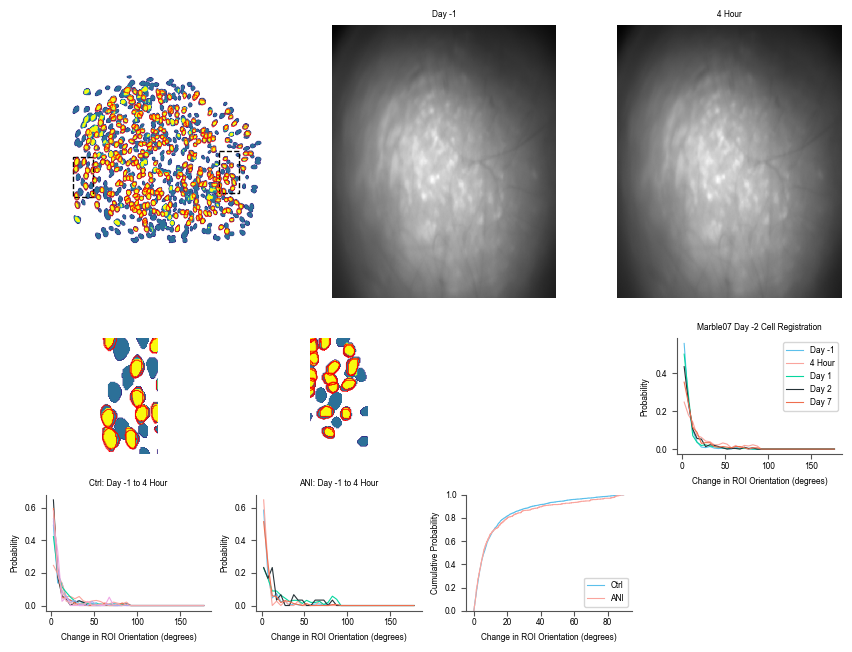

In [12]:
FigRegQ.fig

In [14]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')

FigRegQ.savefig(plot_path / 'FigRegQuality.pdf', scriptname='Fig_Reg_Quality.ipynb')

### Todos
1) Make full plot bigger, maybe reduce lineweight?
2) Move ecdf for Marble07 to 4, 4, 12